# Retrieve Data

Grabbing WebIDs ...
WebID collection complete!
14:29:52: Sending API request... Chunk 1 of 1
14:29:54: Response recieved for 1 tags! (1.39)


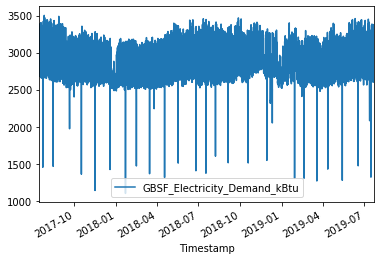

In [2]:
import sys
"""Put the path to the eco-tools folder in the following line... should look something like this one below"""
sys.path.append(r"C:\\Users\\ejgoldbe\\Desktop\\eco-tools/") #path to PI CLient
#if not working: pip install requests-kerberos Desktop
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
from ecotools.pi_client import pi_client
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime
from dateutil.relativedelta import relativedelta
from matplotlib.lines import Line2D
pc = pi_client(root='readonly')
points = pc.search_by_point("GBSF_Electricity_Demand_kBtu")
second_points = pc.search_by_point('aitit4045*')
start = "07-17-2017"
end = "*"
interval = '1h' #can be 1d 2d for days or 1s for seconds or 1m for minutes
calculation = 'summary'
df = pc.get_stream_by_point(points, start = start, 
                            end = end, calculation=calculation,
                            interval=interval)
df = df.dropna()
df.plot()


# Add New Variables

                     GBSF_Electricity_Demand_kBtu  rolling_ten  \
Timestamp                                                        
2017-07-17 00:00:00                   2718.246116  2718.246116   
2017-07-17 01:00:00                   2706.419560  2712.332838   
2017-07-17 02:00:00                   2714.511580  2713.059085   

                     rolling_twenty  rolling_thirty  
Timestamp                                            
2017-07-17 00:00:00     2718.246116     2718.246116  
2017-07-17 01:00:00     2712.332838     2712.332838  
2017-07-17 02:00:00     2713.059085     2713.059085  


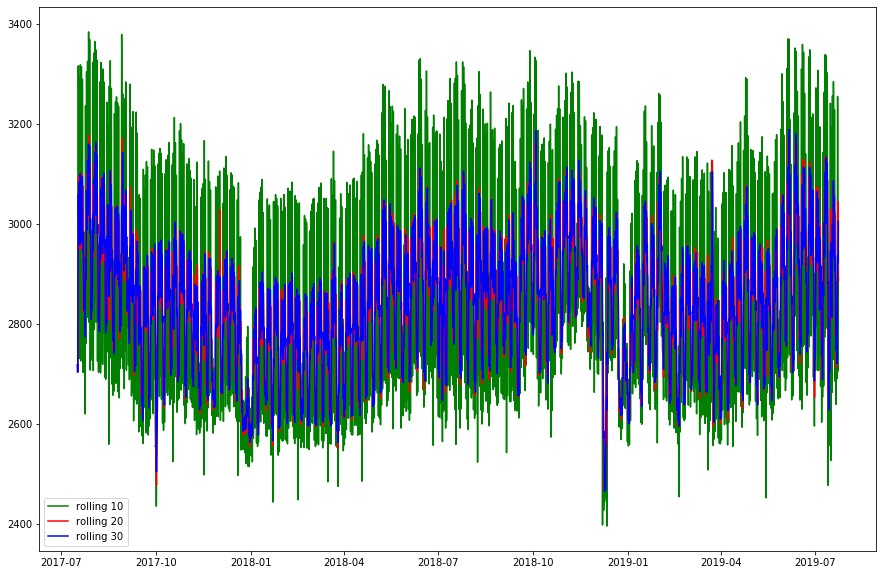

In [3]:
#add a rolling 10 and a rolling 20 mean, as well as a rolling 30
#these look at the past 10, 20, or 30 values (including the current point) and use the mean of those numbers
from functools import reduce


rolling_ten = df.rolling(window=10, min_periods=1).mean()
rolling_twenty = df.rolling(window=20, min_periods=1).mean()
rolling_thirty = df.rolling(window=30, min_periods=1).mean()

#merge new variables
df['rolling_ten'] = rolling_ten.values
df['rolling_twenty'] = rolling_twenty.values
df['rolling_thirty'] = rolling_thirty.values

print(df.head(3))

plt.figure(figsize = (15, 10))
plt.plot(rolling_ten.index, rolling_ten.values, color = 'green', label = 'rolling 10')
plt.plot(rolling_twenty.index, rolling_twenty.values, color = 'red', label = 'rolling 20')
plt.plot(rolling_thirty.index, rolling_thirty.values, color = 'blue', label = 'rolling 30')
plt.legend(loc = 'best')
plt.show()



# Split Into Training + Testing

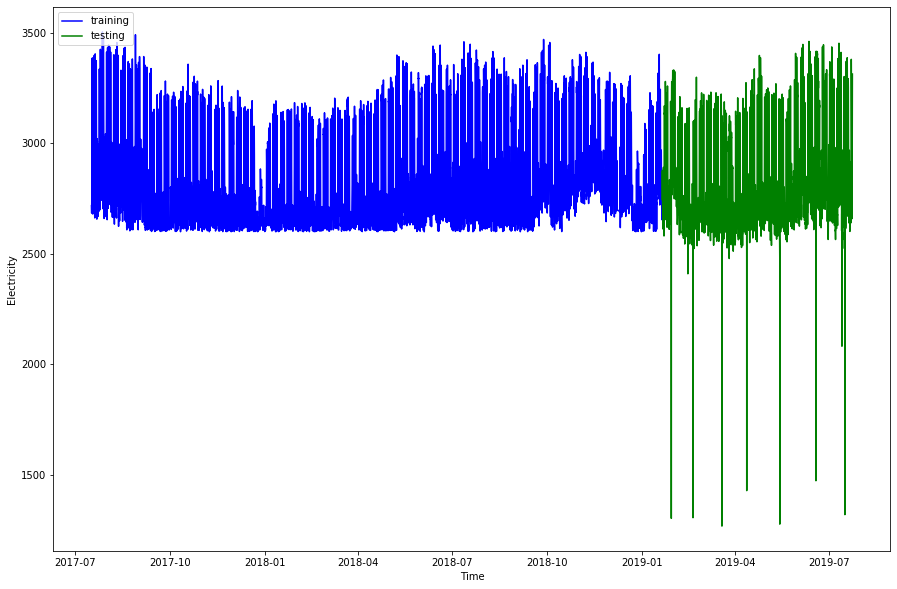

In [4]:
from sklearn.model_selection import train_test_split


X = df.iloc[:, [1, 2, 3]]
y = df.iloc[:, [0]]
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)
#plot the electricity data that was put into training - y_train, y_test
y_train = y_train[y_train.values > 2600]
new_training_indexes = y_train.index.tolist()
X_train = X_train.ix[new_training_indexes]
plt.figure(figsize = (15, 10))
plt.plot(y_train.index, y_train.values, color = 'blue', label = 'training')
plt.plot(y_test.index, y_test.values, color = 'green', label = 'testing')
plt.xlabel("Time")
plt.ylabel("Electricity")
plt.legend(loc = 'upper left')
plt.show()


# Fit Models and Compare Accuracy

In [98]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

param_grid = {'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]}
gb = GradientBoostingRegressor()
grid_search = GridSearchCV(gb, param_grid, cv = 2)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
#refit model with best parameters
new_gb = GradientBoostingRegressor(**grid_search.best_params_)
new_gb.fit(X_train, y_train)
print("Gradient Boosting Regressor accuracy:", new_gb.score(X_test, y_test))
#compare to rf
#fit with the same best params
rf = RandomForestRegressor(**grid_search.best_params_)
rf.fit(X_train, y_train)
print("Random Forest Regressor Accuracy:", rf.score(X_test, y_test))


{'n_estimators': 400}
Gradient Boosting Regressor accuracy: 0.6851296927391859
Random Forest Regressor Accuracy: 0.7058009318529924


# Evaluate Predicted Versus Actual For Best Model

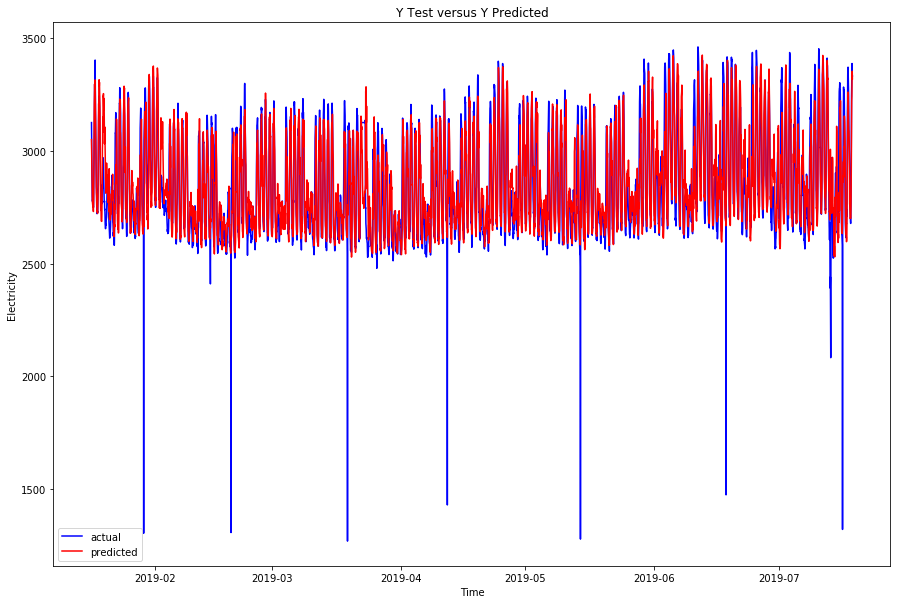

In [99]:
y_preds = rf.predict(X_test)
actual_series = y_test
pred_series = pd.Series(y_preds, index = y_test.index)
plt.figure(figsize = (15, 10))
plt.plot(actual_series.index, actual_series.values, color = 'blue', label = 'actual')
plt.plot(pred_series.index, pred_series.values, color = 'red', label = 'predicted')
plt.xlabel("Time")
plt.ylabel("Electricity")
plt.title("Y Test versus Y Predicted")
plt.legend(loc = 'best')
plt.show()


# Extract Residuals From Actual Vs. Predicted

Timestamp
2019-01-16 17:00:00    75.544238
2019-01-16 18:00:00    52.920383
2019-01-16 19:00:00     2.663486
2019-01-16 20:00:00   -46.605286
2019-01-16 21:00:00   -50.112610
dtype: float64


(-500, 500)

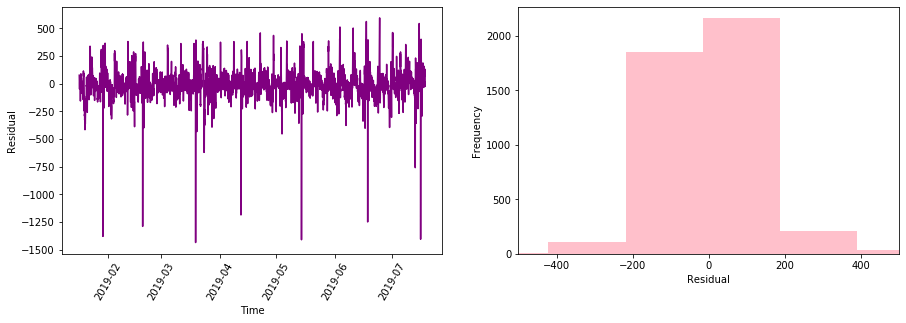

In [100]:
actual = np.ravel(np.array(actual_series.values.tolist()))
actual = list(actual)
preds = pred_series.values.tolist()
resids = [actual[i] - preds[i] for i in range(len(actual))]
resid_series = pd.Series(resids, index = actual_series.index)
#plot residuals
print(resid_series[0:5])
plt.figure(figsize = (15, 10))
plt.subplot(2, 2, 1)
plt.plot(resid_series.index, resid_series.values, color = 'purple')
plt.xticks(rotation=60)
plt.xlabel("Time")
plt.ylabel("Residual")
plt.subplot(2, 2, 2)
plt.hist(resid_series.values.tolist(), color = 'pink')
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.xlim([-500, 500])



# Determine Threshold For Residual Outlier

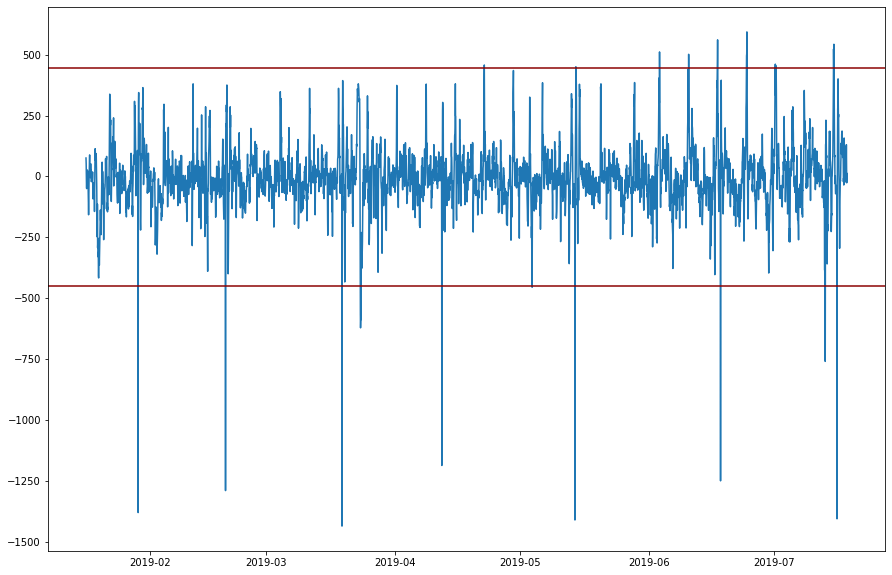

In [112]:
upper_threshold = np.mean(resids) + 3.5*np.std(resids)
lower_threshold = np.mean(resids) - 3.5*np.std(resids)

plt.figure(figsize = (15, 10))
plt.plot(resid_series.index, resid_series.values)
plt.axhline(y = upper_threshold, color = 'darkred')
plt.axhline(y = lower_threshold, color = 'darkred')

# Extract Original Outliers in YTest From Residual Outliers


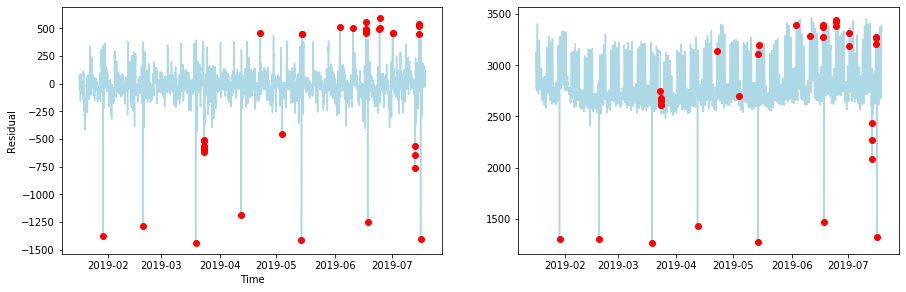

In [113]:
#subset residuals so only outliers
resid_df = pd.DataFrame(resid_series)
resid_df.columns = ['Residual']
outlier_resid_df = resid_df.loc[(resid_df.Residual > upper_threshold) | (resid_df.Residual < lower_threshold)]
outliers = outlier_resid_df['Residual'].tolist()
#plot residuals with outliers
plt.figure(figsize = (15, 10))
plt.subplot(2, 2, 1)
plt.plot(resid_series.index, resid_series.values, color = 'lightblue')
for outlier in outliers:
    index_outlier = resid_series.values.tolist().index(outlier)
    date_outlier = resid_series.index[index_outlier]
    plt.plot(date_outlier, outlier, color = 'red', marker = 'o')
plt.xlabel("Time")
plt.ylabel("Residual")
#plot ytest with outliers
#make y test into a dataframe
y_test_df = pd.DataFrame(y_test)
#since all y_test values are not unique, add an index so that we go back and identify outliers - we can't use y_test.index()..
y_test_df['Index'] = list(range(len(y_test)))
#extract y_test_outliers
outlier_indexes = outlier_resid_df.index.tolist()
y_test_outliers = y_test_df.ix[outlier_indexes]
index_y_test_outliers = y_test_outliers['Index'].tolist()
plt.subplot(2, 2, 2)
plt.plot(y_test.index, y_test['GBSF_Electricity_Demand_kBtu'].values, color = 'lightblue')
for index in index_y_test_outliers:
    outlier = y_test['GBSF_Electricity_Demand_kBtu'].values[index]
    date = y_test.index[index]
    plt.plot(date, outlier, color = 'red', marker = 'o')

#final: determine threshold - min y_test value
